In [1]:
# External dependencies

import numpy as np
import matplotlib.pyplot as plt

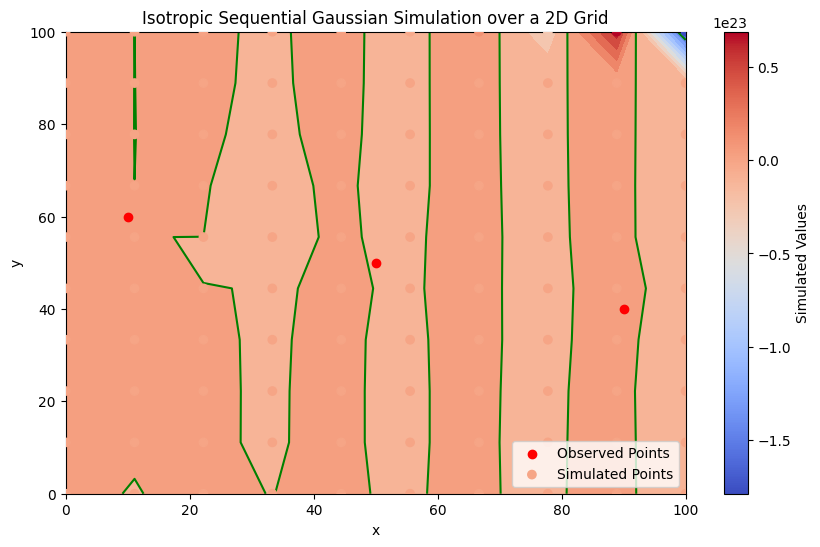

In [2]:
# ISOTROPIC SEQUENTIAL GAUSSIAN SIMULATION

# Covariance function (Gaussian model)
def gaussian_covariance(h, range_param, sill):
    return sill * np.exp(-0.5 * (h / range_param) ** 2)

# Observed 2D points, add or enable/disable as needed
np.random.seed(42)
#X_train = np.array([[10, 10], [50, 10], [90, 10],
#                    [10, 50], [50, 50], [90, 50],
#                    [10, 90], [50, 90], [90, 90]])  # 3 observed points with (x, y) coordinates
#y_train = np.array([0, 0, 0,
#                    1, 1, 1,
#                    0, 0, 0])  # Scalar values corresponding to observed points
x_train = np.array([[10, 60], [50, 50], [90, 40]]) # 3 observed points with (x, y) coordinates
y_train = np.array([1, 1, 1]) # Scalar values corresponding to observed points


# Grid for prediction
x = np.linspace(0, 100, 10)
y = np.linspace(0, 100, 10)
X_grid, Y_grid = np.meshgrid(x, y)
grid_points = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T  # Grid points to simulate

# Covariance model parameters
range_param = 20      # Range of spatial correlation
sill = 1.0              # Variance (sill)

# Sequential Gaussian Simulation
num_simulations = 5
simulated_values = np.zeros(len(grid_points))  # Store simulated values for grid points

# Simulation for each grid point
for i in range(len(grid_points)):
    # Concatenation of observed data and point to be simulated
    X_all = np.vstack([x_train, grid_points[:i + 1]])
    y_all = np.hstack([y_train, simulated_values[:i]])

    # Distance matrix for current points
    distance_matrix = np.linalg.norm(X_all[:, np.newaxis] - X_all, axis=2)

    # Covariance matrix (using distance matrix and covariance function)
    cov_matrix = gaussian_covariance(distance_matrix, range_param, sill)

    # Split of covariance matrix in required submatrices
    cov_11 = cov_matrix[:len(y_all) - 1, :len(y_all) - 1]  # Covariance of known points
    cov_12 = cov_matrix[:len(y_all) - 1, len(y_all) - 1]   # Covariance between known and new point
    cov_22 = cov_matrix[len(y_all) - 1, len(y_all) - 1]    # Variance of the new point

    # Calculation of conditional mean and variance for the simulated value
    cov_11_inv = np.linalg.pinv(cov_11)  # Pseudo-inverse of cov_11
    mean = cov_12.T @ cov_11_inv @ y_all[:-1]  # Calculate the conditional mean
    #print (mean)
    variance = cov_22 - cov_12.T @ cov_11_inv @ cov_12  # Calculate the conditional variance
    #print (variance)

    # Ensure mean and variance are scalars
    mean = mean.item()  
    variance = variance.item() if np.isscalar(variance) else variance[0, 0]

    # Draw of random sample from the normal distribution
    simulated_values[i] = np.random.normal(mean, np.sqrt(max(variance, 0)))  # Ensure non-negative variance


# Plots
plt.figure(figsize=(10, 6))
plt.contourf(X_grid, Y_grid, simulated_values.reshape(X_grid.shape), cmap='coolwarm', levels=20)
plt.contour(X_grid, Y_grid, simulated_values.reshape(X_grid.shape), [1.0], levels=1, colors='g', linestyles='-')
plt.scatter(x_train[:, 0], x_train[:, 1], c='red', label='Observed Points', zorder=5)
plt.scatter(grid_points[:, 0], grid_points[:, 1], c=simulated_values, cmap='coolwarm', label='Simulated Points', zorder=3)
plt.colorbar(label='Simulated Values')
plt.title('Isotropic Sequential Gaussian Simulation over a 2D Grid')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower right')
plt.show()

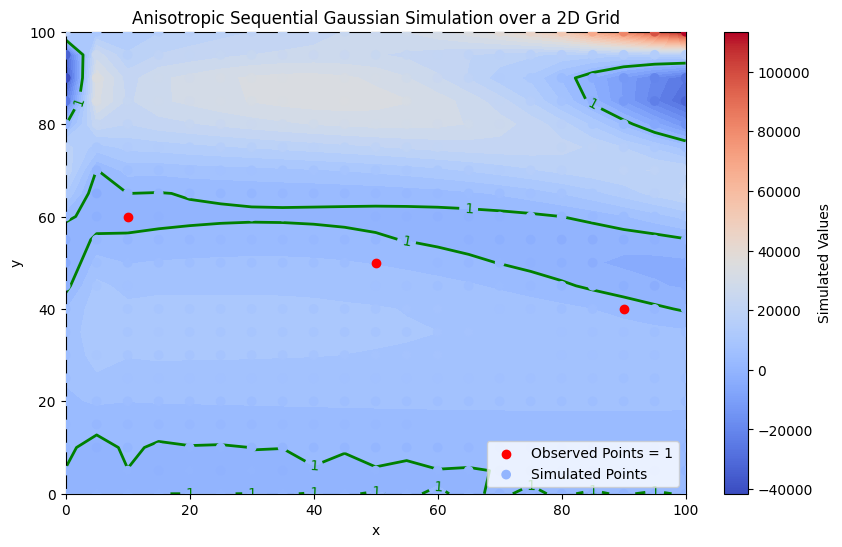

In [3]:
# ANISOTROPIC SEQUENTIAL GAUSSIAN SIMULATION

# Anisotropic Gaussian covariance function
def anisotropic_gaussian_covariance(h, range_param, sill, anisotropy_ratio, angle):
    # Rotation transformation to account for anisotropy and direction
    theta = np.deg2rad(angle)  # Convert angle to radians
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    # Scale the distances by the anisotropy ratio
    h_transformed = h @ R.T
    h_transformed[:, 0] /= anisotropy_ratio  # Apply the anisotropy scaling
    h_scaled = np.linalg.norm(h_transformed, axis=1)
    return sill * np.exp(-0.5 * (h_scaled / range_param) ** 2)

# Observed 2D points, add or enable/disable as needed
np.random.seed(42)
#X_train = np.array([[10, 10], [50, 10], [90, 10],
#                    [10, 50], [50, 50], [90, 50],
#                    [10, 90], [50, 90], [90, 90]])  # 3 observed points with (x, y) coordinates
#y_train = np.array([0, 0, 0,
#                    1, 1, 1,
#                    0, 0, 0])  # Scalar values corresponding to observed points
x_train = np.array([[10, 60], [50, 50], [90, 40]]) # 3 observed points with (x, y) coordinates
y_train = np.array([1, 1, 1]) # Scalar values corresponding to observed points

# Grid for prediction
x = np.linspace(0, 100, 21)
y = np.linspace(0, 100, 21)
X_grid, Y_grid = np.meshgrid(x, y)
grid_points = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T  # Grid points to simulate

# Covariance model parameters
range_param = 100.0  # Range of spatial correlation
sill = 20.0          # Variance (sill)
anisotropy_ratio = 100  # Ratio of anisotropy (greater than 1 stretches horizontally)
angle = 18  # Angle of anisotropy (0 degrees = x-axis)

# Sequential Gaussian Simulation
num_simulations = 1
simulated_values = np.zeros(len(grid_points))  # Store simulated values for grid points

# Simulation for each grid point
for i in range(len(grid_points)):
    # Concatenation of observed data and point to be simulated
    X_all = np.vstack([x_train, grid_points[:i + 1]])
    y_all = np.hstack([y_train, simulated_values[:i]])

    # Distance matrix for current points
    distance_vectors = X_all[:, np.newaxis] - X_all

    # Covariance matrix (using distance matrix and covariance function)
    cov_matrix = anisotropic_gaussian_covariance(
        distance_vectors.reshape(-1, 2),
        range_param,
        sill,
        anisotropy_ratio,
        angle
    ).reshape(len(X_all), len(X_all))

    # Split of covariance matrix in required submatrices
    cov_11 = cov_matrix[:len(y_all) - 1, :len(y_all) - 1]  # Covariance of known points
    cov_12 = cov_matrix[:len(y_all) - 1, len(y_all) - 1]   # Covariance between known and new point
    cov_22 = cov_matrix[len(y_all) - 1, len(y_all) - 1]    # Variance of the new point

    # Calculation of conditional mean and variance for the simulated value
    cov_11_inv = np.linalg.pinv(cov_11)  # Pseudo-inverse of cov_11
    mean = cov_12.T @ cov_11_inv @ y_all[:-1]  # Calculate the conditional mean
    variance = cov_22 - cov_12.T @ cov_11_inv @ cov_12  # Calculate the conditional variance

    # Ensure mean and variance are scalars
    mean = mean.item()  
    variance = variance.item() if np.isscalar(variance) else variance[0, 0]

    # Draw of random sample from the normal distribution
    simulated_values[i] = np.random.normal(mean, np.sqrt(max(variance, 0)))  # Ensure non-negative variance


# Plots
plt.figure(figsize=(10, 6))
plt.contourf(X_grid, Y_grid, simulated_values.reshape(X_grid.shape), cmap='coolwarm', levels=50)
c = plt.contour(X_grid, Y_grid, simulated_values.reshape(X_grid.shape), [1.0], colors='g', linestyles='-', linewidths=2)
plt.scatter(x_train[:, 0], x_train[:, 1], c='red', label='Observed Points = 1', zorder=5)
plt.scatter(grid_points[:, 0], grid_points[:, 1], c=simulated_values, cmap='coolwarm', label='Simulated Points', zorder=3)
plt.colorbar(label='Simulated Values')
plt.title('Anisotropic Sequential Gaussian Simulation over a 2D Grid')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower right')
plt.clabel(c, inline=True, fontsize=10)

plt.show()